In [117]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [118]:
from models.world_dit import WorldDiT

model = WorldDiT().to(device)
model.load_state_dict(
    torch.load("checkpoints/world_base_20251128_223501/model_510.pth")
)

<All keys matched successfully>

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 991.52it/s]

Action: tensor([3], device='cuda:0')


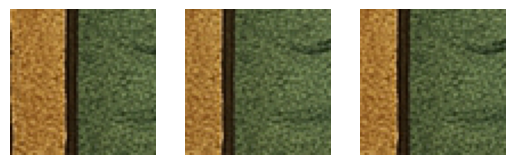

In [ ]:
from train.world import world_ddim_sample
from dataset import WorldDataset, SelectSampleDataset
from train.diffusion import get_noise_schedule

torch.manual_seed(42)

T = 400
ddim_steps = 100

noise_schedule = get_noise_schedule(T, device=device)
dataset = WorldDataset("data/world_map.png")
dataset = SelectSampleDataset(dataset, num_samples=16)


# only show the final step
steps_to_show = [0]

xt = torch.randn(1, 3, 64, 64).to(device)

start, action, end = dataset[4]
start = start.to(device).unsqueeze(0)
action = torch.tensor(0).to(device).unsqueeze(0)

snapshots = world_ddim_sample(
    xt,
    model,
    start,
    action,
    noise_schedule,
    ddim_steps,
    steps_to_show,
)

fig, axes = plt.subplots(1, 3)
# dont show axes
for ax in axes.flat:
    ax.axis("off")

start = start.squeeze(0)
print(f"Action: {action}")
axes[0].imshow(start.permute(1, 2, 0).cpu().numpy())
axes[1].imshow(snapshots[0].permute(1, 2, 0).cpu().numpy())
axes[2].imshow(end.permute(1, 2, 0).cpu().numpy())